In [102]:
import sys
import os
os.environ['PROJ_DATA'] = "/pscratch/sd/p/plutzner/proj_data"
import xarray as xr
import torch
import torchinfo
import random
import numpy as np
import importlib as imp
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cartopy.crs as ccrs
import json
import pickle
import gzip

import math
import torch
# import shash
from shash.shash_torch import Shash
#import matplotlib.colors as mcolorsxx|

%load_ext autoreload
%autoreload 2
import utils
import utils.filemethods as filemethods
import databuilder.data_loader as data_loader
from databuilder.data_generator import multi_input_data_organizer
from databuilder.data_generator import ClimateData
import databuilder.data_generator as data_generator
from utils.filemethods import open_data_file as open_data_file
from databuilder.data_loader import universaldataloader
import analysis.analysis_metrics as analysis_metrics
from analysis.analysis_metrics import load_pickle
from utils.utils import get_config
import matplotlib.cm as cm
from analysis.analysis_metrics import maximum_difference

print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")
print(f"pytorch version = {torch.__version__}")

# https://github.com/victoresque/pytorch-template/tree/master

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
python version = 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]
numpy version = 1.26.4
xarray version = 2024.5.0
pytorch version = 2.0.0.post104


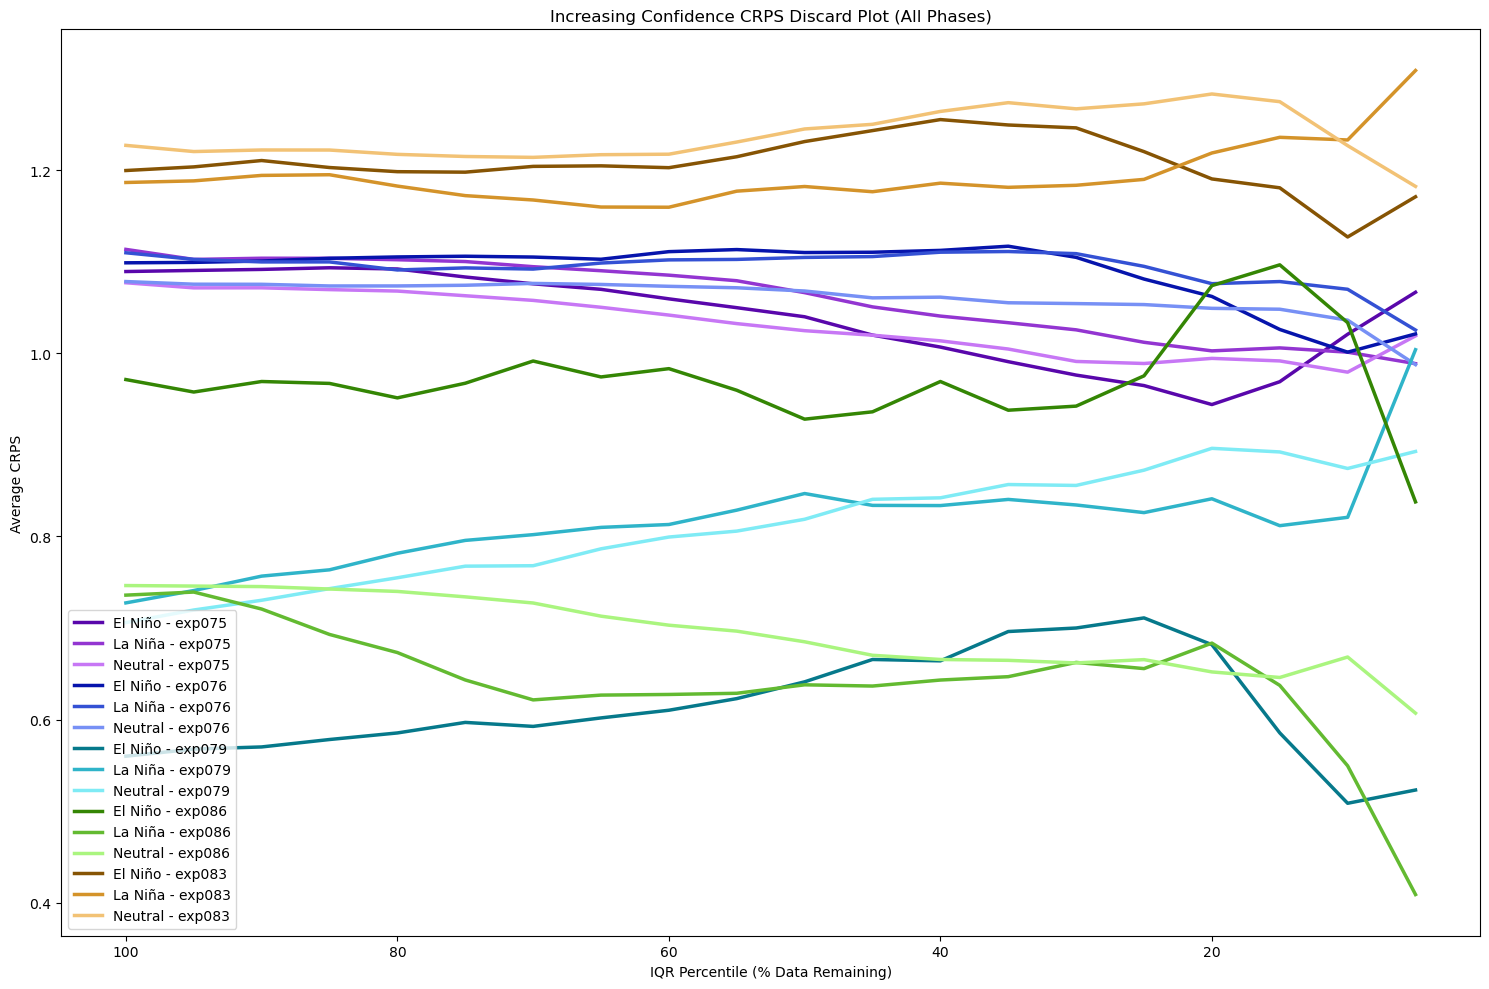

In [40]:
# Open discard plot data from appropriate experiments: 
E3SM_cnn_E3SM_exp = "exp075"
E3SM_snn_E3SM_exp = "exp076"
OBS_cnn_OBS_exp = "exp079"
OBS_snn_OBS_exp = "exp086"
OBS_cnn_E3SM_exp = "exp083"

plt.figure(figsize=(15, 10))
plt.gca().invert_xaxis()  # high confidence = low IQR = right side of plot

exps = [E3SM_cnn_E3SM_exp, E3SM_snn_E3SM_exp, OBS_cnn_OBS_exp, OBS_snn_OBS_exp, OBS_cnn_E3SM_exp]
color_themes = {
    0: ["#5907AB", "#9335D1", "#C777F5"], 
    1:[ "#0614AC", "#3451D4", "#7790F5"],
    2: ["#06798B", "#2FB4C9", "#7FEBF5"],
    3: ['#348604', '#63BA31', '#AAF57F'],
    4: ['#865404', '#D4932A', '#F2C275'],
    5: ['#890730', '#D03F6D', '#F484A7']
}
for iexp, experiment_name in enumerate(exps):
    filename = str("/pscratch/sd/p/plutzner/E3SM/saved/output/" + str(experiment_name) + "/" + str(experiment_name) + "_combined_ENSO_IQR_discard_data.pkl")
    try:
        with open(filename, 'rb') as f:
            discard_data = pickle.load(f)
    except (pickle.UnpicklingError, EOFError, UnicodeDecodeError):
        try:
            # If it fails, try gzip
            with gzip.open(filename, 'rb') as f:
                discard_data = pickle.load(f)
        except Exception as e:
            raise RuntimeError(f"Failed to load file with both normal and gzip methods: {e}")

    percentile_dict = discard_data['percentiles']
    crps_dict = discard_data['crps']

    plt.plot(percentile_dict['EN'], crps_dict['EN'], label=f'El Niño - {experiment_name}', linewidth = 2.5, color = color_themes[iexp][0])
    plt.plot(percentile_dict['LN'], crps_dict['LN'], label=f'La Niña - {experiment_name}', linewidth = 2.5, color = color_themes[iexp][1])
    plt.plot(percentile_dict['NE'], crps_dict['NE'], label=f'Neutral - {experiment_name}', linewidth = 2.5, color = color_themes[iexp][2])

    plt.xlabel('IQR Percentile (% Data Remaining)')
    plt.ylabel('Average CRPS')
    plt.title('Increasing Confidence CRPS Discard Plot (All Phases)')
    plt.legend()
    plt.tight_layout()
    plt.savefig('/pscratch/sd/p/plutzner/E3SM/saved/figures/COMBINED/CRPS_discard_plot_combined.png', format = 'png',  dpi = 250)

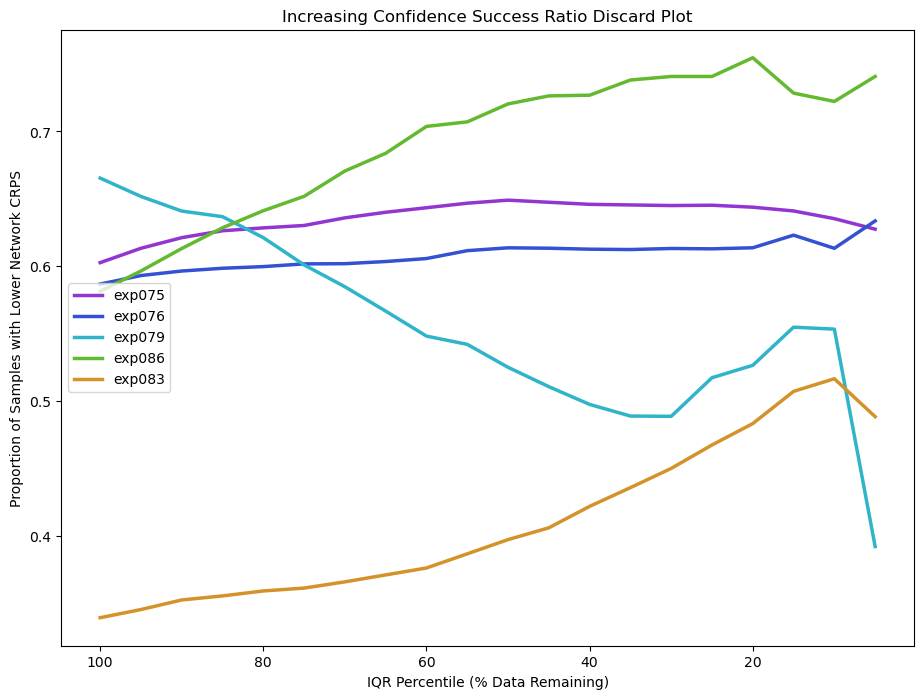

In [ ]:
# Open discard plot data from appropriate experiments: 
E3SM_cnn_E3SM_exp = "exp075"
E3SM_snn_E3SM_exp = "exp076"
OBS_cnn_OBS_exp = "exp079"
OBS_snn_OBS_exp = "exp086"
OBS_cnn_E3SM_exp = "exp083"

plt.figure(figsize=(11, 8))
plt.gca().invert_xaxis()  # high confidence = low IQR = right side of plot

exps = [E3SM_cnn_E3SM_exp, E3SM_snn_E3SM_exp, OBS_cnn_OBS_exp, OBS_snn_OBS_exp, OBS_cnn_E3SM_exp]
color_themes = {
    0:  "#9335D1", 
    1:  "#3451D4",
    2:  "#2FB4C9",
    3:  '#63BA31',
    4:  '#D4932A',
    5:  '#D03F6D'
}
for iexp, experiment_name in enumerate(exps):
    filename = str("/pscratch/sd/p/plutzner/E3SM/saved/output/" + str(experiment_name) + "/" + str(experiment_name) + "_success_ratio.pkl")
    try:
        with open(filename, 'rb') as f:
            discard_data = pickle.load(f)
    except (pickle.UnpicklingError, EOFError, UnicodeDecodeError):
        try:
            # If it fails, try gzip
            with gzip.open(filename, 'rb') as f:
                discard_data = pickle.load(f)
        except Exception as e:
            raise RuntimeError(f"Failed to load file with both normal and gzip methods: {e}")
    
    percentiles = discard_data['percentiles']
    avg_success_ratio = discard_data['avg_success_ratio']

    plt.plot(percentiles, avg_success_ratio, color=color_themes[iexp], label = str(experiment_name), linewidth = 2.5)

    # Place the label near the end of the line
    # x_pos = percentiles[0]
    # y_pos = avg_success_ratio[0]
    # plt.text(x_pos + 0.5, y_pos + 0.012, experiment_name, color=color_themes[iexp], fontsize=11, va='center')

    plt.xlabel('IQR Percentile (% Data Remaining)')
    plt.ylabel('Proportion of Samples with Lower Network CRPS')
    # plt.ylim([min(avg_success_ratio) - 0.2, max(avg_success_ratio) + 0.1])
    plt.title('Increasing Confidence Success Ratio Discard Plot')
    plt.legend(loc = 'center left')
    plt.savefig('/pscratch/sd/p/plutzner/E3SM/saved/figures/COMBINED/combined_SuccessRatio_DiscardPlot.png', format = 'png',  dpi = 250) 


### ----------- exp038 vs exp079 COMPARISON --------------

In [77]:
fn_output_83 = '/pscratch/sd/p/plutzner/E3SM/saved/output/exp083/exp075T_exp083_OOD_INFERENCE_network_SHASH_parameters.pkl'
fn_output_79 = '/pscratch/sd/p/plutzner/E3SM/saved/output/exp079/exp079_network_SHASH_parameters.pkl'

fn_network_crps_83 = '/pscratch/sd/p/plutzner/E3SM/saved/output/exp083/exp083_CRPS_network_values.pkl'
fn_network_crps_79 = '/pscratch/sd/p/plutzner/E3SM/saved/output/exp079/exp079_CRPS_network_values.pkl'

fn_climo_crps_83 = '/pscratch/sd/p/plutzner/E3SM/saved/output/exp083/exp083_CRPS_climatology_values.pkl'
fn_climo_crps_79 = '/pscratch/sd/p/plutzner/E3SM/saved/output/exp079/exp079_CRPS_climatology_values.pkl'

fn_target_83 = '/pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp083_trimmed_test_dat.nc'
fn_target_79 = '/pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp079_trimmed_test_dat.nc'

# open inputs and outputs: 
output_83 = load_pickle(fn_output_83)
output_79 = load_pickle(fn_output_79)

network_crps_83 = load_pickle(fn_network_crps_83)
network_crps_79 = load_pickle(fn_network_crps_79)

climo_crps_83 = load_pickle(fn_climo_crps_83)
climo_crps_79 = load_pickle(fn_climo_crps_79)

# The first half of the target data is actually climatology
# Isolate the years 1981-2023 for the actual predictions
target_83 = open_data_file(fn_target_83)
climatology_years = [1940, 1980]
analysis_years = [1981, 2023]
climatology_83 = target_83['y'].sel(time=slice(str(climatology_years[0]) + '-01-01', str(climatology_years[1]) + '-12-31'))
target_83 = target_83['y'].sel(time=slice(str(analysis_years[0]) + '-01-01', str(analysis_years[1]) + '-12-31'))
# trim output to just the indices corresponding with analysis years
testing_target_time_83 = target_83.time.sel(time = slice(str(analysis_years[0]) + '-01-01', str(analysis_years[1]) + '-12-31'))
analysis_years_indices = np.where(np.isin(target_83.time.values, testing_target_time_83.values))[0]
output_83 = output_83[analysis_years_indices, ...]
print(f"modified target length: {target_83.shape}")
print(f"climatology length: {climatology_83.shape}")

target_79 = open_data_file(fn_target_79)
print(target_79.y)
target_79 = target_79.y
print(f"length of target_79 = {len(target_79)}")
targettime_79 = target_79.time
print(f"target time 79: {targettime_79}")

modified target length: (7822,)
climatology length: (7431,)
<xarray.DataArray 'y' (time: 1037)> Size: 8kB
[1037 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 8kB 2018-02-12 2018-02-13 ... 2023-12-17
length of target_79 = 1037
target time 79: <xarray.DataArray 'time' (time: 1037)> Size: 8kB
array(['2018-02-12T00:00:00.000000000', '2018-02-13T00:00:00.000000000',
       '2018-02-14T00:00:00.000000000', ..., '2023-12-15T00:00:00.000000000',
       '2023-12-16T00:00:00.000000000', '2023-12-17T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 8kB 2018-02-12 2018-02-13 ... 2023-12-17
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         valid_time_bnds
    axis:           T


In [78]:
# Isolate overlapping dates of interest from exp038: 
test_start = 2018
test_end = 2023
month_day_start = '-02-12'
month_day_end = '-12-17'

target_83_filtered = target_83.sel(time=slice(str(test_start) + month_day_start, str(test_end) + month_day_end))
targettime_83_filtered = testing_target_time_83.sel(time=slice(str(test_start) + month_day_start, str(test_end) + month_day_end))

matching_times = np.isin(target_83['time'].values, target_83_filtered['time'].values)
exp083_target_index = np.where(matching_times)[0]
print(f"exp083_target_index = {exp083_target_index}")
print(f"length of target_index: {len(exp083_target_index)}")

output_83_filtered = output_83[exp083_target_index, ...]
network_crps_83_filtered = network_crps_83[exp083_target_index, ...]
climo_crps_83_filtered = climo_crps_83[exp083_target_index, ...]


exp083_target_index = [6785 6786 6787 ... 7819 7820 7821]
length of target_index: 1037


In [4]:
# date-for-date, compare CRPS between exp083 and exp079: 
crps_compare1 = 100 * np.sum(network_crps_79 < network_crps_83_filtered) / len(network_crps_83_filtered)
print(f"Proportion of exp079 predictions with lower CRPS than exp083 predictions: {round(crps_compare1, 2)}%")

crps_compare2 = 100 * np.sum(network_crps_83_filtered < network_crps_79) / len(network_crps_79)
print(f"Proportion of exp083 predictions with lower CRPS than exp079 predictions: {round(crps_compare2, 2)}%")

Proportion of exp079 predictions with lower CRPS than exp083 predictions: 78.21%
Proportion of exp083 predictions with lower CRPS than exp079 predictions: 21.79%


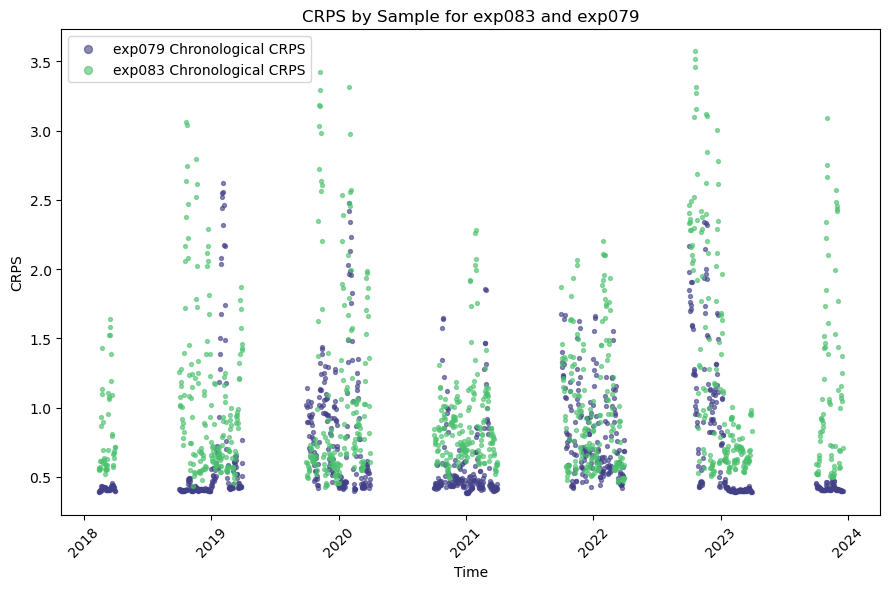

In [79]:
# CPRS by Sample Scatter: 
plt.figure(figsize=(9, 6))
plt.scatter(targettime_79, network_crps_79, s=8, alpha=0.6, color='#424086', label='exp079 Chronological CRPS')
plt.scatter(targettime_83_filtered, network_crps_83_filtered, s=8, alpha=0.6, color='#4ac16d', label='exp083 Chronological CRPS')
plt.xlabel('Time')
plt.ylabel('CRPS')
plt.title('CRPS by Sample for exp083 and exp079')
plt.legend(markerscale = 2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/pscratch/sd/p/plutzner/E3SM/saved/figures/COMBINED/CRPS_by_sample_exp083_exp079.png', format='png', dpi=250)


# Box and whisker plot of the same data binned by 6 month increments: 


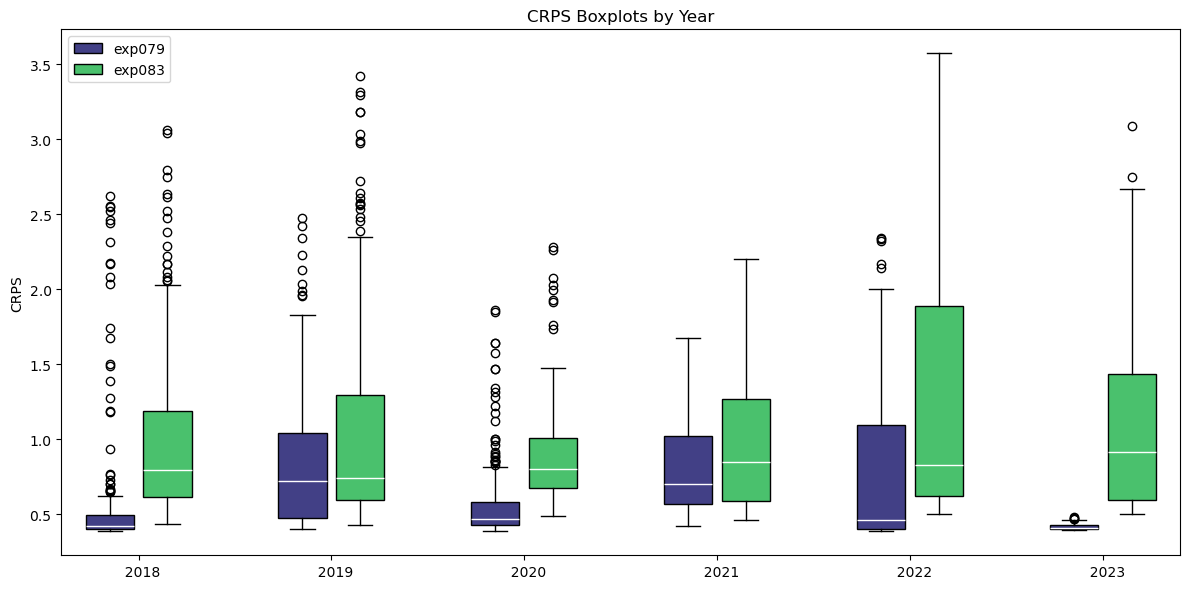

In [80]:
# Define bin edges based on visual cluster breaks
bin_edges = pd.to_datetime([
    "2018-02-12", "2019-10-01", "2020-10-01",
    "2021-10-01", "2022-10-01", "2023-10-01", "2024-10-01"
]).to_numpy()

bin_labels = [f"  {i+2018}" for i in range(len(bin_edges) - 1)]

# Create lists to hold CRPS values for each bin
binned_crps_079 = []
binned_crps_083 = []

# Bin crps_079
for i in range(len(bin_edges) - 1):
    mask = (targettime_79 >= bin_edges[i]) & (targettime_79 < bin_edges[i+1])
    binned_crps_079.append(network_crps_79[mask])

# Bin crps_083
for i in range(len(bin_edges) - 1):
    mask = (targettime_83_filtered >= bin_edges[i]) & (targettime_83_filtered < bin_edges[i+1])
    binned_crps_083.append(network_crps_83_filtered[mask])


fig, ax = plt.subplots(figsize=(12, 6))

# Set positions for side-by-side boxes
positions_079 = np.arange(len(bin_labels)) * 2.0
positions_083 = positions_079 + 0.6

# Plot
bp1 = ax.boxplot(binned_crps_079, positions=positions_079, widths=0.5, patch_artist=True,
                 boxprops=dict(facecolor="#424086"), medianprops=dict(color='white'))
bp2 = ax.boxplot(binned_crps_083, positions=positions_083, widths=0.5, patch_artist=True,
                 boxprops=dict(facecolor="#4ac16d"), medianprops=dict(color='white'))

# Set ticks and labels
xtick_positions = (positions_079 + positions_083) / 2
ax.set_xticks(xtick_positions)
ax.set_xticklabels(bin_labels)
ax.set_ylabel("CRPS")
ax.set_title("CRPS Boxplots by Year")
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ["exp079", "exp083"], loc="upper left")

plt.tight_layout()
plt.savefig('/pscratch/sd/p/plutzner/E3SM/saved/figures/COMBINED/CRPS_boxplot_exp083_exp079.png', format='png', dpi=250)

### SHASH Analysis:

shape of x_values_83 = (1000,)
shape of p83 = (1000, 1037)
shape of x_values_79 = (1000,)
shape of p79 = (1000, 1037)


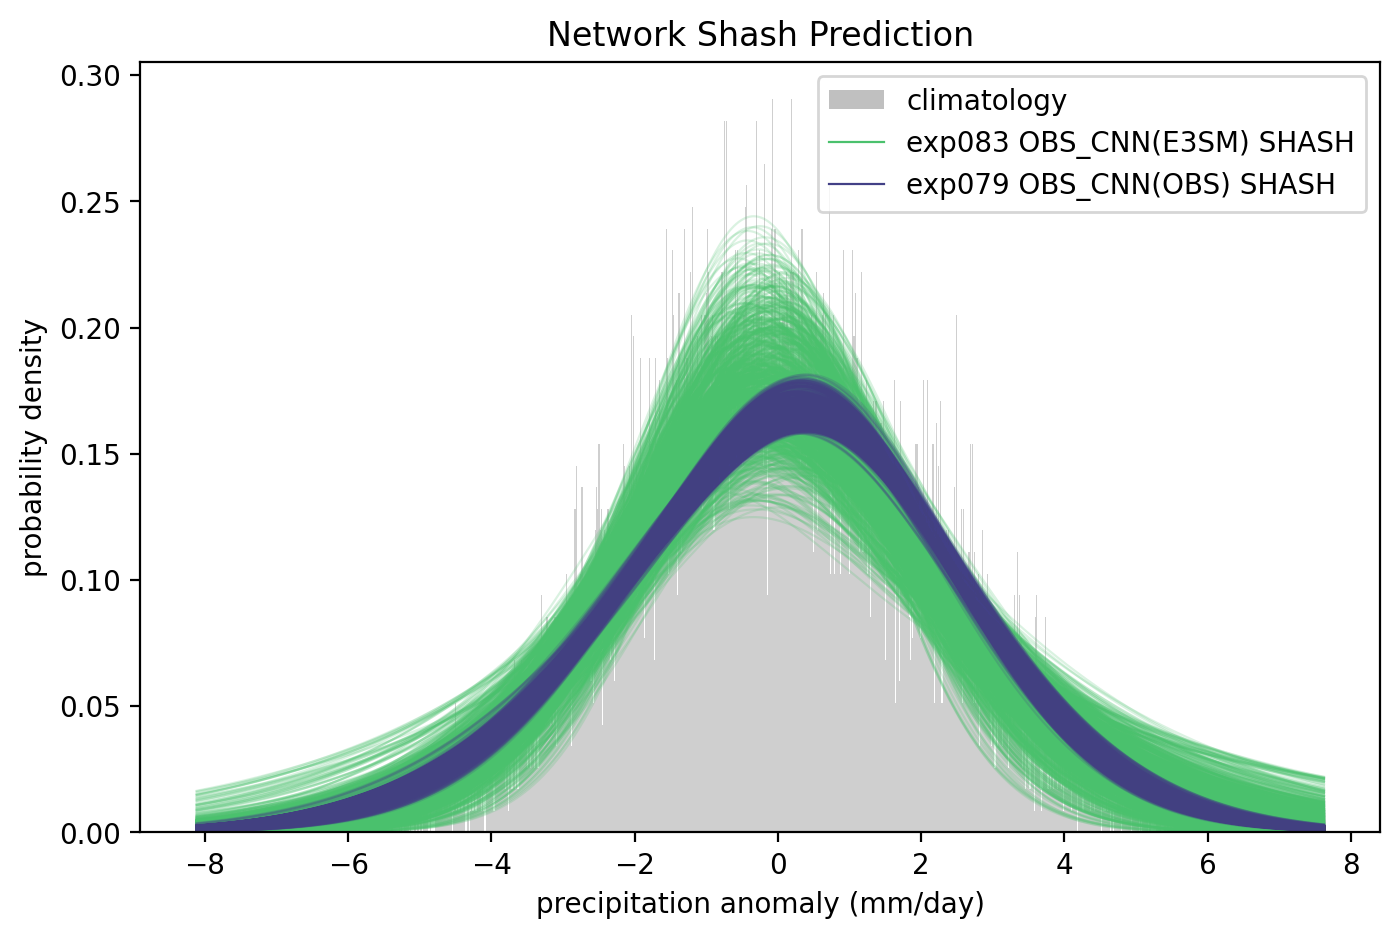

In [81]:
dist_83 = Shash(output_83_filtered)
dist_79 = Shash(output_79)

x_values_83 = np.linspace(np.min(climatology_83) - 2, np.max(climatology_83), 1000)
x_values_79 = np.linspace(np.min(climatology_83) - 2, np.max(climatology_83), 1000)

p83 = dist_83.prob(x_values_83).numpy()
p79 = dist_79.prob(x_values_79).numpy()

plt.figure(figsize=(8, 5), dpi=200)
plt.hist(
    climatology_83, x_values_83, density=True, color="silver", alpha=0.75, label="climatology"
)

print(f"shape of x_values_83 = {x_values_83.shape}")
print(f"shape of p83 = {p83.shape}")
print(f"shape of x_values_79 = {x_values_79.shape}")
print(f"shape of p79 = {p79.shape}")

plt.plot(x_values_83, p83, linewidth = 0.8, alpha = 0.2, color = "#4ac16d")
plt.plot(x_values_79, p79, linewidth = 0.8, alpha = 0.2, color = "#424086")
plt.plot(x_values_83[0], p83[0, 0], linewidth = 0.8, alpha = 0.2, label = f"exp083 OBS_CNN(E3SM) SHASH", color = "#4ac16d")
plt.plot(x_values_79[0], p79[0, 0], linewidth = 0.8, alpha = 0.2, label = f"exp079 OBS_CNN(OBS) SHASH", color = "#424086")
plt.xlabel("precipitation anomaly (mm/day)")
plt.ylabel("probability density")
plt.title("Network Shash Prediction")
leg = plt.legend(loc = 'upper right')
for lh in leg.legend_handles: 
    lh.set_alpha(1)
# plt.ylim([0, 0.375])

plt.savefig('/pscratch/sd/p/plutzner/E3SM/saved/figures/COMBINED/SHASH_exp083_exp079_ALL_testset_samples.png', format='png', dpi=250)

Proportionate variance of mu for exp083 vs exp079: 11.510000228881836
Proportionate variance of sigma for exp083 vs exp079: 16.030000686645508
Proportionate variance of gamma for exp083 vs exp079: 20.309999465942383
Proportionate variance of tau for exp083 vs exp079: 23.780000686645508


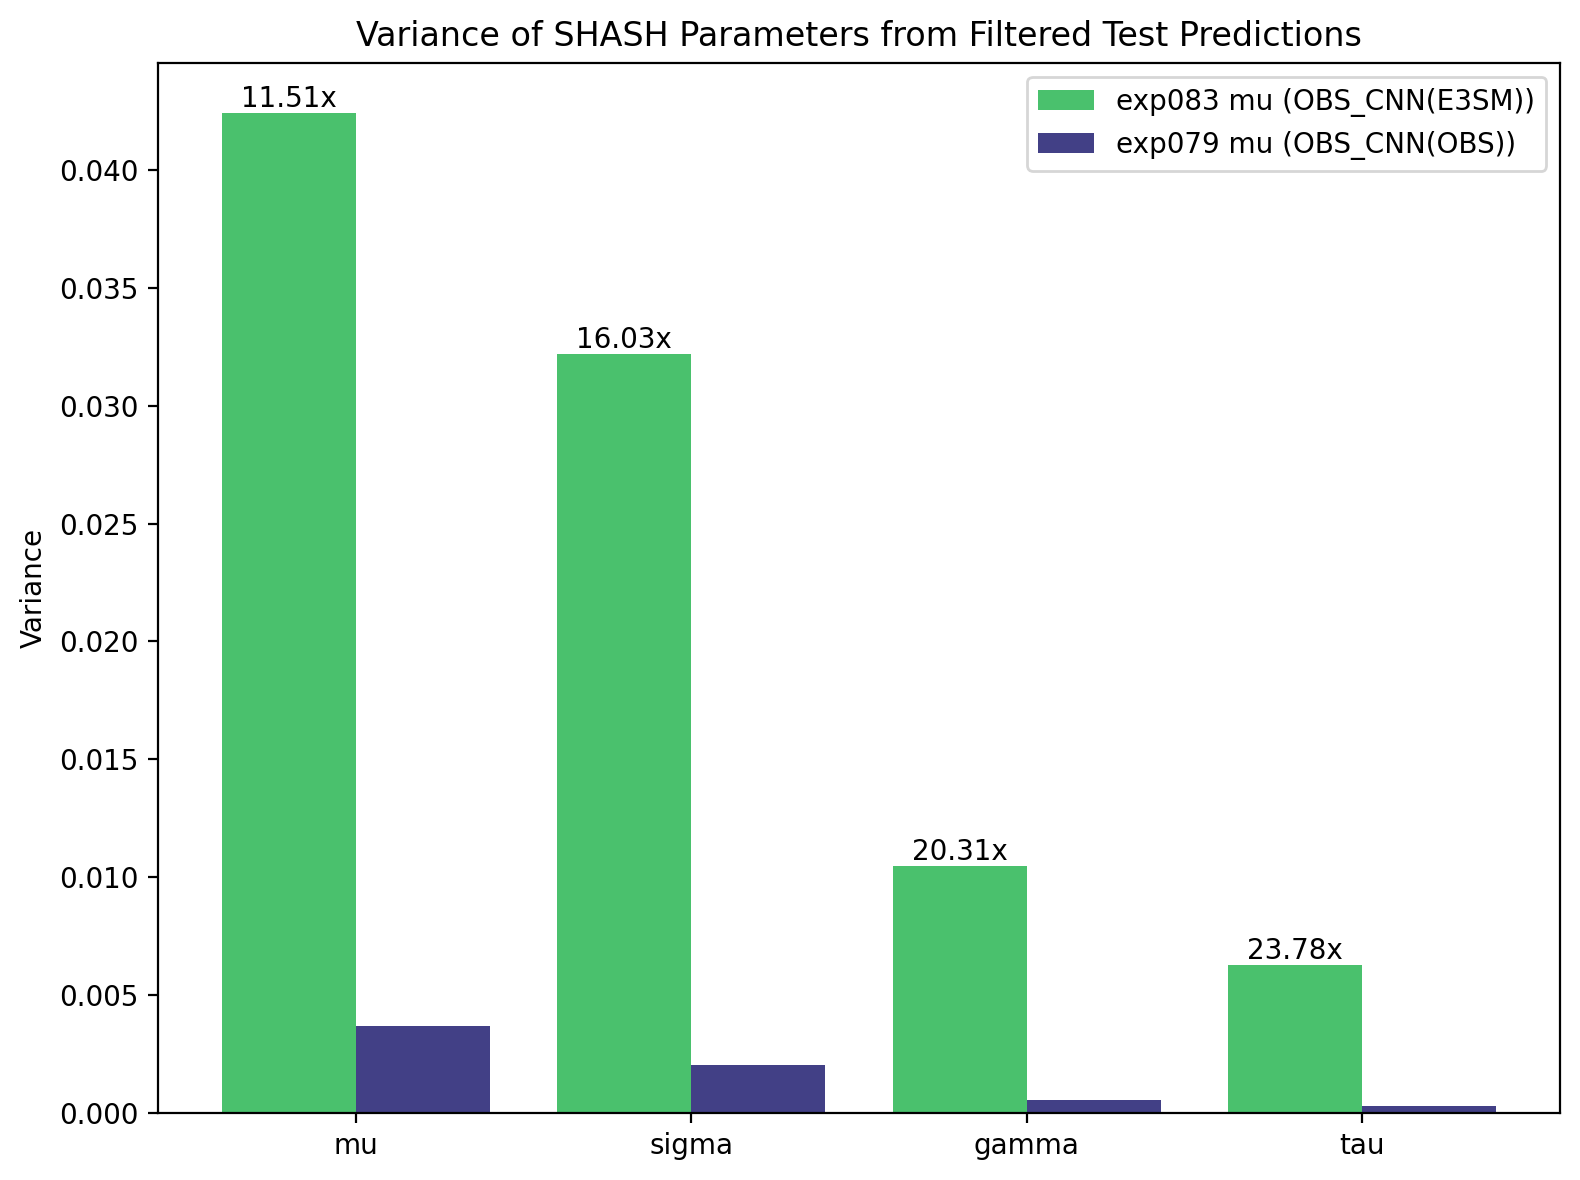

In [82]:
# Variance of shash parameters from filtered test predictions: 
# bar plot for sigma, mu, gamma, tau
cats = ['mu', 'sigma', 'gamma', 'tau']
var_dict = {
    'mu': [np.var(output_83_filtered[:, 0]), np.var(output_79[:, 0])],
    'sigma': [np.var(output_83_filtered[:, 1]), np.var(output_79[:, 1])],
    'gamma': [np.var(output_83_filtered[:, 2]), np.var(output_79[:, 2])],
    'tau': [np.var(output_83_filtered[:, 3]), np.var(output_79[:, 3])],
}

plt.figure(figsize=(8, 6), dpi=200)
for i, cat in enumerate(cats):
    plt.bar(i - 0.2, var_dict[cat][0], width=0.4, color='#4ac16d', label=f'exp083 {cat} (OBS_CNN(E3SM))' if i == 0 else "")
    plt.bar(i + 0.2, var_dict[cat][1], width=0.4, color='#424086', label=f'exp079 {cat} (OBS_CNN(OBS))' if i == 0 else "")
    proportionate_var = var_dict[cat][0] / var_dict[cat][1]
    proportionate_var = round(proportionate_var, 2)
    print(f"Proportionate variance of {cat} for exp083 vs exp079: {round(proportionate_var, 2)}")
    plt.text(i - 0.2, var_dict[cat][0], f"{proportionate_var:.2f}x", ha='center', va='bottom', fontsize=10)
plt.xticks(range(len(cats)), cats)
plt.ylabel('Variance')
plt.title('Variance of SHASH Parameters from Filtered Test Predictions')
plt.legend()
plt.tight_layout()
plt.savefig('/pscratch/sd/p/plutzner/E3SM/saved/figures/COMBINED/SHASH_parameter_variance_exp083_exp079.png', format='png', dpi=250)


exp083 extreme samples: [[-0.91800064  2.3032608   0.2304587   0.78133005]
 [ 0.4923417   2.017544    0.04750006  0.8840396 ]
 [ 0.521096    1.9925265   0.01390103  0.8776856 ]
 [-0.24405342  1.5209869   0.19022253  0.7228704 ]
 [-0.37490657  2.4179955   0.2741262   0.7580819 ]
 [-0.34089753  2.423792    0.27783126  0.7784174 ]
 [-0.13096689  1.9254966  -0.27392933  0.7508896 ]
 [-0.35004404  1.750464    0.34478754  0.6653471 ]
 [-0.3430016   1.721162    0.35554898  0.66477776]
 [-0.27775085  1.8106165   0.2730181   0.60873693]
 [-0.27947292  2.0424747   0.16400936  1.046463  ]
 [-0.14386652  1.9838654   0.11474523  1.074697  ]]


/tmp/ipykernel_187674/3870622932.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(dates))


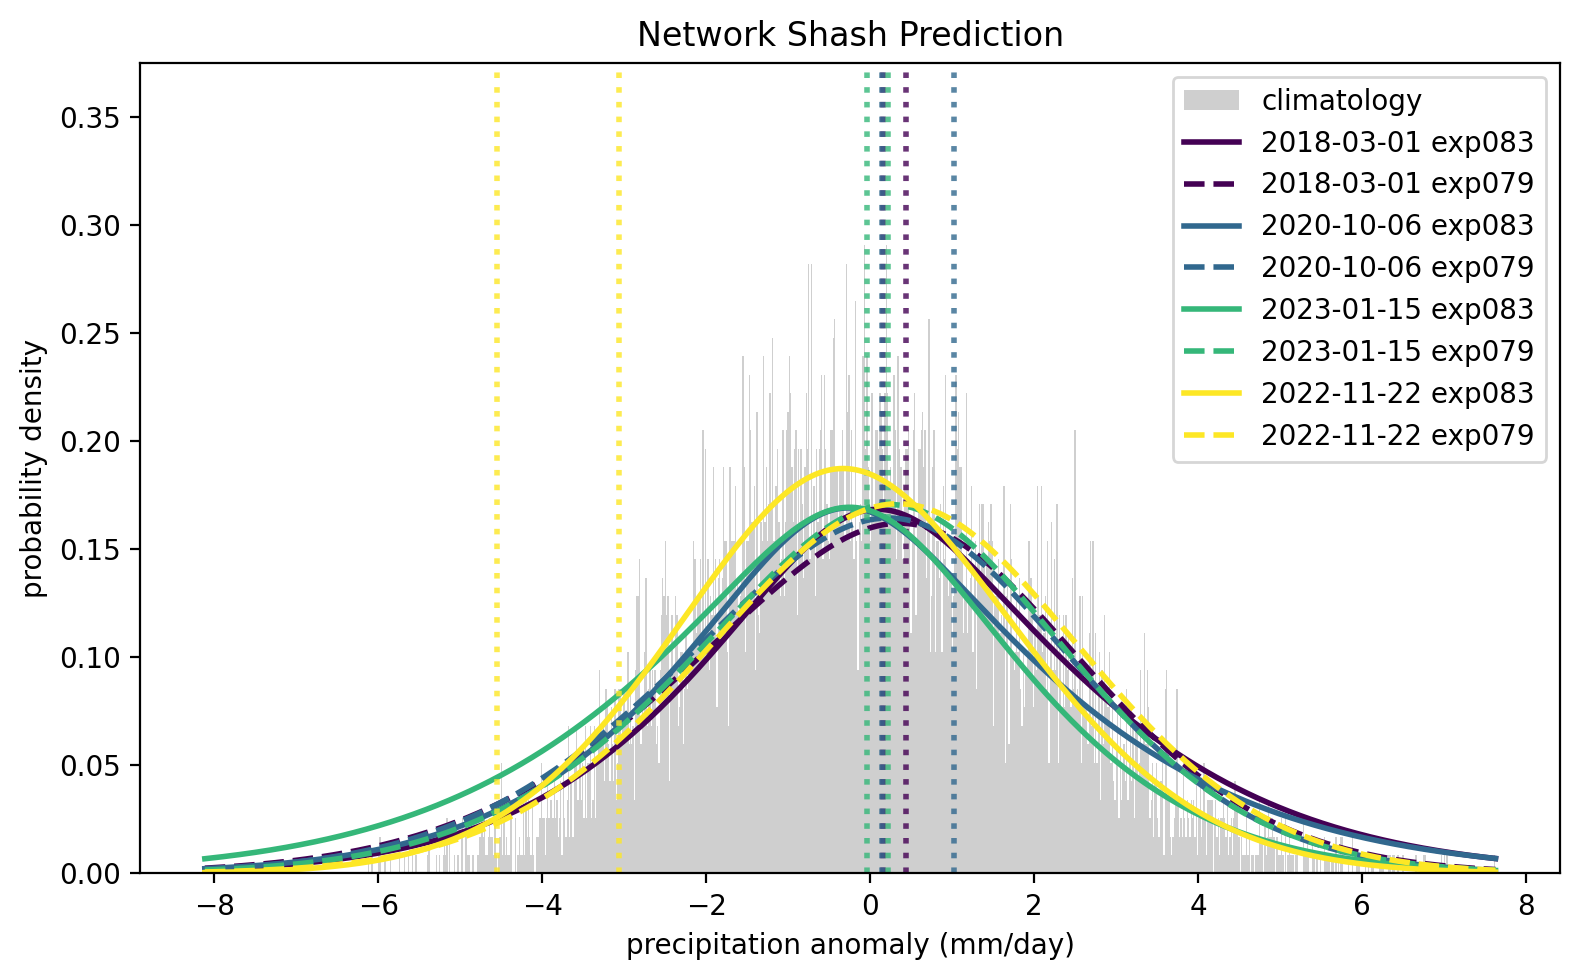

In [103]:
# Select date of interest: 

date1 = pd.to_datetime("2018-03-01")
date2 = pd.to_datetime("2020-10-06")
date3 = pd.to_datetime("2023-01-15")
date4 = pd.to_datetime("2022-11-22")

# Isolate dates where sigma and mu parameters are most extreme in magnitude: 
num = 5
extreme_samps_83 = maximum_difference(output_83_filtered, required_samples = num, tau_frozen=False)
extreme_samps_79 = maximum_difference(output_79, required_samples = num, tau_frozen=False)
print(f"exp083 extreme samples: {extreme_samps_83}")

dates = [date1, date2, date3, date4]
# isolate shash params from output_83_filtered and output_79
single_predictions_83 = np.zeros([len(dates), 4])
single_predictions_79 = np.zeros([len(dates), 4])
true_target_values_83 = np.zeros([len(dates), 1])
true_target_values_79 = np.zeros([len(dates), 1])   

# Prepare data outside the plotting loop
for i, date in enumerate(dates):
    single_predictions_83[i, ...] = output_83_filtered[targettime_83_filtered == date, ...]
    single_predictions_79[i, ...] = output_79[targettime_79 == date, ...]
    true_target_values_83[i] = target_83_filtered.sel(time=date).values
    true_target_values_79[i] = target_79.sel(time=date)

# # Prepare data outside the plotting loop
# for i, date in enumerate(dates):
#     single_predictions_83[i, ...] = output_83_filtered[targettime_83_filtered == date, ...]
#     single_predictions_79[i, ...] = output_79[targettime_79 == date, ...]
#     true_target_values_83[i] = target_83_filtered.sel(time=date).values
#     true_target_values_79[i] = target_79.sel(time=date)

plt.figure(figsize=(8, 5), dpi=200)

# Plot climatology histogram
x_values_83 = np.linspace(np.min(climatology_83) - 2, np.max(climatology_83), 1000)
plt.hist(climatology_83, x_values_83, density=True, color="silver", alpha=0.75, label="climatology")

# Get colormap
cmap = cm.get_cmap('viridis', len(dates))

# Plot each date's predictions
for i, date in enumerate(dates):
    color = cmap(i)  # Get color for this date
    
    # Create distributions
    dist_83 = Shash(single_predictions_83[i:i+1, ...])  # Keep batch dimension
    dist_79 = Shash(single_predictions_79[i:i+1, ...])  # Keep batch dimension
    
    # Calculate probabilities
    p83 = dist_83.prob(x_values_83).numpy()
    p79 = dist_79.prob(x_values_83).numpy()  # Use same x_values for both
    
    # Plot curves and vertical lines with same color
    date_str = date.strftime('%Y-%m-%d')
    
    # Plot SHASH curves
    plt.plot(x_values_83, p83, linewidth=2, linestyle='-', 
             color=color, label=f"{date_str} exp083")
    plt.plot(x_values_83, p79, linewidth=2, linestyle='--', 
             color=color, label=f"{date_str} exp079")
    
    # Plot vertical lines for target values (same color, no separate legend entries)
    plt.axvline(x=true_target_values_83[i], linestyle=':', color=color, alpha=0.8, linewidth=2)
    plt.axvline(x=true_target_values_79[i], linestyle=':', color=color, alpha=0.8, linewidth=2)

plt.xlabel("precipitation anomaly (mm/day)")
plt.ylabel("probability density")
plt.title("Network Shash Prediction")
plt.legend(loc='upper right')
plt.ylim([0, 0.375])
plt.tight_layout()
plt.show()